In [21]:
# imports for libraries and local modules
import main
import pandas as pd
import numpy as np
import json
import networkx as nx
import itertools
import re
import matplotlib
import csv
import matplotlib.pyplot as plt
import ipympl
%matplotlib widget

# The big question
## Does the CS department belong more to the college of science or the college of engineering?

The way we will do this is by running multiple community detection algorithms and then comparing the comunnti that have The CS department science departments and engineering departments. Going off of multiple scores and found communities that we can find which college the CS department 

### community detection algorithms to run

In [22]:
Gf2022, Gs2023, G_reg = main.create_graphs()
Gf2022.size()
# nx.draw(Gf2022)
l = list(Gf2022.nodes())
for i in l:
    if i.startswith('s'): Gf2022.remove_node(i)
l = list(Gf2022.nodes())
for i in l:
    if i.startswith('g'): Gf2022.remove_node(i)
l = list(Gf2022.nodes())
# for i in l:
#     if i.startswith('d'): Gf2022.remove_node(i)
# for i in nx.adjacency_matrix(G_reg):
#     print(i)
# for i in nx.connected_components(Gf2022):
#     print(i)


### draws graph in custom shell layout

In [23]:
def draw_similarity_shell_graph(G, w=100, c=12, t=12, l=None, labels=None, cont=False):
    widths = nx.get_edge_attributes(G, 'weight')
    colors = nx.get_edge_attributes(G, 'color')
    alpha = nx.get_node_attributes(G, 'alpha')
    nodelist = G.nodes()

    edge_colors = {}
    for k in widths:
        widths[k] *= w
        edge_colors[k] = colors.get(k, 'lightblue')
    for node in nodelist:
        if node not in alpha:
            alpha[node] = 1
        
    if not cont:
        plt.figure(figsize=(10,8))
    
    if l is None:
        pos = nx.shell_layout(G)
    else:
        pos = l
        
    _labels = {
        "text": dict(zip(nodelist, nodelist)),
        "pos": pos,
        "size": t
    }
    if labels is not None:
        _labels.update(labels)
        
    nx.draw_networkx_nodes(G,pos,
                           nodelist=alpha.keys(),
                           node_size=c*10,
                           node_color='#999999',
                           alpha=list(alpha.values()))
    e = nx.draw_networkx_edges(G,pos,
                           edgelist = widths.keys(),
                           width=list(widths.values()),
                           edge_color=list(edge_colors.values()),
                           alpha=0.9)
    nx.draw_networkx_labels(G, pos=_labels["pos"],
                            labels=_labels["text"],
                            font_size=_labels["size"],
                            font_color='black')
    plt.box(False)
    plt.show()

### removing isolated nodes

In [24]:
# remove isolated nodes
l = [i for i in list(Gf2022.nodes()) if len(list(Gf2022.neighbors(i))) == 0]
print(len(list(Gf2022.nodes())))
for i in l:
    Gf2022.remove_node(i)
print(len(list(Gf2022.nodes())))

7680
4859


### lists of nodes per each class program. dept. etc.

In [25]:
########### useful lists
dlist = [i for i in list(Gf2022.nodes()) if i.startswith('d')]

### testing to see if colleges will end up in their own comunities or others
girvan newman (takes too long 40 min+) deleted

### simrank similarity

In [26]:
sims = nx.simrank_similarity(Gf2022, tolerance=.0001)

### clustering functions based on node similarity 
#### input : dict of dicts and set of nodes. 
#### return : list of cluster sets

In [27]:
def merge_2_in_list(lst, i:set, j:set):
    lst.remove(i)
    lst.remove(j)
    comb = set.union(i, j)
    lst.append(comb)
    print(comb)
    return lst

def setsim(sim_l, x, y):
    most = 0
    for i in x:
        for j in y:
            if sim_l[i][j] > most:
                most = sim_l[i][j]
    return most

def merge_best(slist, sim_l):
    most = 0 
    best = ({},{})
    for x in slist:
        for y in slist:
            if not x == y:
                if setsim(sim_l, x, y) > most:
                    best = (x,y)
                    most = setsim(sim_l, x, y)
    slist = merge_2_in_list(slist, best[0], best[1])
    return slist

### forms graph of nodes and similarities being the edges

In [28]:
department_similarity = nx.Graph()
for i in sims:
    if i.startswith('d'):
        for j in sims[i]:
            if j.startswith('d'):
                if (not i == j) and (not i == "dNone") and (not i == "dNone"):
                    department_similarity.add_edge(i,j,weight = sims[i][j])
department_similarity.remove_node('dNone')

### further tunes shape of graph plot to have all labels clean (no overlap)

0


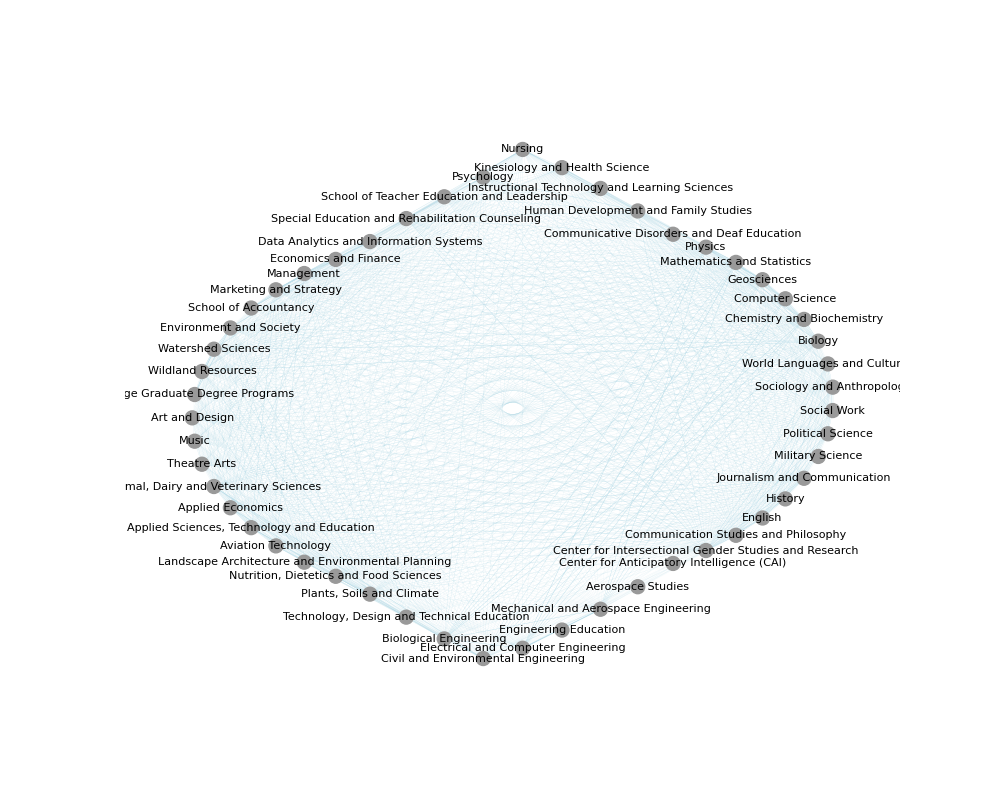

In [29]:
labels = {}
for node in department_similarity:
    labels[node] = node[1:]
layout = nx.shell_layout(department_similarity)

for node in department_similarity:
    if abs(layout[node][0]) < 0.5:
        scale_factor = 2 - abs(layout[node][0])
    else:
        scale_factor = 1.5
    if layout[node][0] > 0:
        bias_factor = 0.05
    else:
        bias_factor = -0.1
    layout[node] = np.asarray([layout[node][0], float(layout[node][1]) * scale_factor + bias_factor])

found = 0
while found < 100:
    found_any = False
    for a in department_similarity:
        for b in department_similarity:
            if a == b:
                continue
            if abs(layout[a][0] - layout[b][0]) < 0.5 and abs(layout[a][1] - layout[b][1]) < 0.01:
                layout[a][1] += 0.02
                found_any = True
    if not found_any:
        break
    else:
        found += 1
print(found)
        
draw_similarity_shell_graph(department_similarity, w=10, c=10, t=8, labels=dict(text=labels), l=layout)

In [30]:
dsets = [{i} for i in dlist]

while len(dsets) > 40:
    dsets = merge_best(dsets, sims)

# for s in dsets:
#     print(s)
# print()

sim_scores = []

for i in dlist:
    # print(i, sims['dComputer Science'][i])
    sim_scores.append((i, sims['dComputer Science'][i]))

scores_df = pd.DataFrame(sim_scores)
scores_df = scores_df.sort_values(by=[1], ascending=False)
scores_df.columns = ("departments","similarity score")
scores_df.iloc[1:10]


{'dElectrical and Computer Engineering', 'dMechanical and Aerospace Engineering'}
{'dWatershed Sciences', 'dCollege Graduate Degree Programs'}
{'dManagement', 'dMarketing and Strategy'}
{'dWatershed Sciences', 'dEnvironment and Society', 'dCollege Graduate Degree Programs'}
{'dWatershed Sciences', 'dEnvironment and Society', 'dCollege Graduate Degree Programs', 'dWildland Resources'}
{'dMechanical and Aerospace Engineering', 'dElectrical and Computer Engineering', 'dMathematics and Statistics'}
{'dEnglish', 'dCenter for Intersectional Gender Studies and Research'}
{'dSchool of Accountancy', 'dMarketing and Strategy', 'dManagement'}
{'dCivil and Environmental Engineering', 'dAnimal, Dairy and Veterinary Sciences'}
{'dElectrical and Computer Engineering', 'dMathematics and Statistics', 'dMechanical and Aerospace Engineering', 'dPhysics'}
{'dMathematics and Statistics', 'dMechanical and Aerospace Engineering', 'dComputer Science', 'dElectrical and Computer Engineering', 'dPhysics'}
{'dSch

,departments,similarity score
33,dMathematics and Statistics,0.028097
14,dElectrical and Computer Engineering,0.026339
34,dPhysics,0.021381
16,dMechanical and Aerospace Engineering,0.020187
32,dGeosciences,0.017547
30,dChemistry and Biochemistry,0.016342
12,dBiological Engineering,0.015676
10,"dPlants, Soils and Climate",0.015141
29,dBiology,0.015002


Computer science first unions with

{'dMathematics and Statistics', 'dComputer Science', 'dCollege Graduate Degree Programs', 'dBiology', 'dWatershed Sciences', 'dElectrical and Computer Engineering', 'dWildland Resources', 'dGeosciences', 'dEnvironment and Society', 'dPhysics', 'dMechanical and Aerospace Engineering', 'dChemistry and Biochemistry'}
departments CS is most similar to.

- Mathematics and Statistics 0.01756198138117592
- Electrical and Computer Engineering 0.013817100358897143
- Physics 0.012728859470477173
- Mechanical and Aerospace Engineering 0.00894455550982796
- Geosciences 0.008916532749064133
- Plants, Soils and Climate 0.007701980279592437
- Chemistry and Biochemistry 0.0075383358937803875
- Biology 0.007196324834269024
- Biological Engineering 0.006135921440022809
- Sociology and Anthropology 0.005347494805756185

### Common Neighbor Centrality

In [31]:
cnc_sim = nx.common_neighbor_centrality(Gf2022, alpha=.8)

In [32]:
# for i in cnc_sim:
#     print(i)
cnc_lst = []
for i in cnc_sim:
    if i[0].startswith('d') and i[1].startswith('d'):
        cnc_lst.append(i)
        
        

#### functions to combine a list for tuples instead of dictionaries

In [33]:
def setsim2(sim_l, x, y):
    most = 0
    for i in x:
        for j in y:
            for k in sim_l:
                if k[0] == i and k[1] == j:    
                    if k[2] > most:
                        most = k[2]
    return most

def merge_best2(slist, sim_l):
    most = 0 
    best = ({},{})
    for x in slist:
        for y in slist:
            if not x == y:
                if setsim2(sim_l, x, y) > most:
                    best = (x,y)
                    most = setsim2(sim_l, x, y)
    slist = merge_2_in_list(slist, best[0], best[1])
    return slist

In [40]:
for i in cnc_lst:
    if i[0] == 'dComputer Science':
        print(i)

('dComputer Science', 'dInstructional Technology and Learning Sciences', 242.94999999999996)
('dComputer Science', 'dCenter for Intersectional Gender Studies and Research', 161.96666666666664)
('dComputer Science', 'dAnimal, Dairy and Veterinary Sciences', 242.94999999999996)
('dComputer Science', 'dGeosciences', 242.94999999999996)
('dComputer Science', 'dJournalism and Communication', 242.94999999999996)
('dComputer Science', 'dApplied Economics', 242.94999999999996)
('dComputer Science', 'dKinesiology and Health Science', 242.94999999999996)
('dComputer Science', 'dMathematics and Statistics', 242.94999999999996)
('dComputer Science', 'dHistory', 242.94999999999996)
('dComputer Science', 'dSocial Work', 242.94999999999996)
('dComputer Science', 'dManagement', 242.94999999999996)
('dComputer Science', 'dAerospace Studies', 0.0)
('dComputer Science', 'dEnglish', 242.94999999999996)
('dComputer Science', 'dBiological Engineering', 242.94999999999996)
('dComputer Science', 'dWorld Langu

CS highest similarities according to common_neighbor_centrality
interestingly enough more than 70% of departments shared the highest similarity score in this centraility measure.

In [35]:
dsets2 = [{i} for i in dlist]

while len(dsets2) > 20:
    dsets2 = merge_best2(dsets2, cnc_lst)

for i in dsets2:
    print(i)
    

# {'dTheatre Arts', 'dLandscape Architecture and Environmental Planning'}
# {'dApplied Economics', 'dAnimal, Dairy and Veterinary Sciences'}
# {'dNutrition, Dietetics and Food Sciences', 'dCenter for Intersectional Gender Studies and Research'}

{'dMusic', 'dArt and Design'}
{'dTheatre Arts', 'dLandscape Architecture and Environmental Planning'}
{'dApplied Economics', 'dAnimal, Dairy and Veterinary Sciences'}
{'dApplied Sciences, Technology and Education', 'dAviation Technology'}
{'dNutrition, Dietetics and Food Sciences', 'dCenter for Intersectional Gender Studies and Research'}
{'dPlants, Soils and Climate', 'dTechnology, Design and Technical Education'}
{'dBiological Engineering', 'dCivil and Environmental Engineering'}
{'dPolitical Science', 'dElectrical and Computer Engineering'}
{'dCommunication Studies and Philosophy', 'dMechanical and Aerospace Engineering'}
{'dSociology and Anthropology', 'dEnglish'}
{'dHistory', 'dSocial Work'}
{'dJournalism and Communication', 'dWorld Languages and Cultures'}
{'dPolitical Science', 'dMilitary Science', 'dElectrical and Computer Engineering'}
{'dChemistry and Biochemistry', 'dBiology'}
{'dGeosciences', 'dComputer Science'}
{'dMathematics and Statistics', 'dPhysics'}
{'dCommunicative 

A lot of these groupings do no make sense i believe that the degree centrality obscures how these nodes interact comparing common neighbors

## k-cliques
### Graph is not connected enough to form any meaningfull clique communities. none show with a k above 3

In [42]:
clique_lst = []
genclique = nx.community.k_clique_communities(Gf2022, 2)
for i in genclique:
    if True in (t.startswith('d') for t in i):
        clique_lst.append(i)

# for i in clique_lst:
#     print(i)


### Panther similarity
only finds the nearest n nodes. difficult output when you only want to find specific node types. so we grabbed the first college

In [37]:
Gf2022, Gs2023, G_reg = main.create_graphs()
Gf2022.size()
# nx.draw(Gf2022)
l = list(Gf2022.nodes())
for i in l:
    if i.startswith('s'): Gf2022.remove_node(i)
l = [i for i in list(Gf2022.nodes()) if len(list(Gf2022.neighbors(i))) == 0]
print(len(list(Gf2022.nodes())))
for i in l:
    Gf2022.remove_node(i)
print(len(list(Gf2022.nodes())))

bruh = nx.panther_similarity(Gf2022, 'dComputer Science', 20)
print(bruh)

7689
4868
{'p33681': 0.00045128616557187984, 'p34264': 0.00040114325828611544, 'p33683': 0.00033428604857176287, 'p33682': 0.00033428604857176287, 'p33679': 0.0003008574437145866, 'p33684': 0.00028414314128599846, 'p34334': 0.00021728593157164586, 'cCS 6250': 0.000117000117000117, 'cCS 5250': 0.00010028581457152886, 'gCollege of Science': 0.00010028581457152886, 'cCS 6990': 8.357151214294072e-05, 'cCS 2610': 8.357151214294072e-05, 'p34260': 8.357151214294072e-05, 'cSOC 6150': 6.685720971435257e-05, 'cCS 6970': 6.685720971435257e-05, 'cCS 5260': 6.685720971435257e-05, 'cCS 7970': 6.685720971435257e-05, 'cPSC 6150': 6.685720971435257e-05, 'cCS 2420': 6.685720971435257e-05}


debugging code for jaccard coeffecient

In [38]:
g_programs = nx.subgraph_view(Gf2022, filter_node=lambda x: x.startswith("p") or x.startswith("c"))
programs = list(filter(lambda x: x.startswith("p"), g_programs.nodes))
courses = list(filter(lambda x: x.startswith("c"), g_programs.nodes))
ebunch = []
for i in range(len(programs)):
    for j in range(i + 1, len(programs)):
        ebunch.append((programs[i], programs[j]))

minors = []
for minor in g_programs.nodes():
    if minor.startswith('p'):
        if g_programs.nodes[minor]['attr']['program_type'] == 'Minor':
            minors.append(minor)

program_similarity = nx.Graph()
for u, v, p in nx.jaccard_coefficient(g_programs, ebunch):
    program_similarity.add_edge(u, v, weight=p)



program = "p33681"
if program in minors:
    minors.remove("p33681")
#Show the similarity between the programs
for minor2 in minors:
    print(f"{g_programs.nodes[program]['attr']['desc']} and {g_programs.nodes[minor2]['attr']['desc']} have a similarity of {program_similarity[program][minor2]['weight']}")

Computer Science - BS and Art - Minor have a similarity of 0.0
Computer Science - BS and Art History - Minor have a similarity of 0.0
Computer Science - BS and Film Studies - Minor have a similarity of 0.0
Computer Science - BS and Basic Music - Minor have a similarity of 0.0
Computer Science - BS and Elementary School Music Teaching - Minor have a similarity of 0.0
Computer Science - BS and Music Studies - Minor have a similarity of 0.0
Computer Science - BS and Piano Pedagogy - Minor have a similarity of 0.0
Computer Science - BS and General Theatre Studies - Minor have a similarity of 0.0
Computer Science - BS and Theatre Arts Teaching - Minor have a similarity of 0.0
Computer Science - BS and Animal and Dairy Sciences - Minor have a similarity of 0.0
Computer Science - BS and Animal Biotechnology - Minor have a similarity of 0.0
Computer Science - BS and Bioveterinary Science - Minor have a similarity of 0.0
Computer Science - BS and Equine - Minor have a similarity of 0.0
Computer